In [100]:
import sys
sys.path.append('..')

import os
from sqlalchemy import create_engine, text
import geopandas as gpd
import pandas as pd
from geopandas.tools import sjoin
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
from shapely import wkb
import simplekml

from utilities_amigocloud import AmigocloudFunctions

In [91]:
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import API_AMIGOCLOUD_TOKEN_ADM
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

In [92]:
API_AMIGOCLOUD_TOKEN_ADM

'A:cf5xrxU3HgHj9FkLMiY5wW9LBFmvYDQG2TQ5FY'

In [141]:
# leer los dos shps de siembra y puntos de planificacion
PATH_SIEMBRA = RUTA_UNIDAD_ONE_DRIVE + r'Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\SHP\SIEMBRAS_.shp'
PATH_CAT = RUTA_UNIDAD_ONE_DRIVE + r'Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\SHP\CATASTRO_S09_MIERCOLES.shp'
PATH_KML = RUTA_UNIDAD_ONE_DRIVE + r'Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\KML_PLAN'

gdf_siembras = gpd.read_file(PATH_SIEMBRA)
gdf_cat = gpd.read_file(PATH_CAT)

In [142]:
PATH_SIEMBRA

'G:\\Ingenio Azucarero Guabira S.A\\UTEA - SEMANAL - EQUIPO AVIACION UTEA\\Trichogramma\\2025\\SHP\\SIEMBRAS_.shp'

In [143]:
def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

def obtener_planificacion_no_procesado():
    engine = obtener_engine()
    try:
        query = """
            SELECT id_os, geom, cod_ca, nom_ca, obs, procesado
            FROM drones_control_bio.planificacion_ctrl_bio
            WHERE procesado=false;
        """
        gdf = gpd.read_postgis(query, engine, geom_col='geom')
        return gdf
    except Exception as e:
        print(f"❌ Error en la consulta: {e}")
        return gpd.GeoDataFrame()
    return None

def obtener_parte_diario_por_id_os(id_os):
    engine = obtener_engine()
    try:
        query = f"""
            SELECT * FROM drones_control_bio.parte_diario_ctrl_bio where os = {id_os}
        """
        gdf = gpd.read_postgis(query, engine, geom_col='geom')
        return gdf
    except Exception as e:
        print(f"❌ Error en la consulta: {e}")
        return gpd.GeoDataFrame()
    return None

def filtrar_os_y_quitar_caracteres(gdf, ors):
    # filtrar la semana de interes
    gdf_puntos_select = gdf[gdf['id_os'] == ors]
    gdf_puntos_sem = gdf_puntos_select.copy()
    #quita caracteres especiales
    gdf_puntos_sem['nom_ca'] = gdf_puntos_sem['nom_ca'].str.replace(r'[\r\n\t]', '', regex=True)
    return gdf_puntos_sem

def marcar_como_procesado(id_os):
    engine = obtener_engine()  # tu función que crea el engine
    try:
        with engine.begin() as conn:
            query = text("""
                UPDATE drones_control_bio.planificacion_ctrl_bio
                SET procesado = true
                WHERE id_os = :id_os
            """)
            conn.execute(query, {"id_os": id_os})
            print(f"✔️ id_os {id_os} marcado como procesado.")
    except Exception as e:
        print(f"❌ Error al actualizar: {e}")
    return None

def crear_puntos_individuales(gdf):
    # Crear una lista para almacenar los nuevos registros de puntos individuales
    point_records = []
    # Iterar sobre cada registro en el GeoDataFrame original
    for idx, row in gdf.iterrows():
        multipoint_geom = row.geom
        # Verificar si la geometría es de tipo multipunto
        if isinstance(multipoint_geom, MultiPoint):
            for point in multipoint_geom.geoms:
                # Crear un nuevo registro para cada punto individual
                new_record = row.copy()
                new_record.geometry = point
                point_records.append(new_record)
        else:
            # Si la geometría ya es un punto, simplemente añadir el registro original
            point_records.append(row)
    
    # Crear un nuevo GeoDataFrame con los registros de puntos individuales
    puntos_indi = gpd.GeoDataFrame(point_records, geometry='geom', crs=gdf.crs)
    return puntos_indi

def definir_lotes_solicitud(gdf_puntos_indi):
    # Crear un GeoDataFrame vacío para almacenar los puntos que no intersectan con ningún polígono de siembra
    puntos_indi_solicitado = gdf_puntos_indi[~gdf_puntos_indi.geometry.apply(lambda point: any(gdf_siembras.contains(point)))]
    
    # identifoca los lotes que se intersectan
    gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi_solicitado, how='inner', predicate='intersects')    
    
    # filtra los lotes intersectados en la capa original
    poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
    
    # copy
    poligonos_intersect_cat = poligonos_intersect_cat.copy()
    poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]
    # Cambiar el nombre de la columna 'old_name' a 'new_name'
    poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)
    # CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
    # Iterar sobre cada punto y encontrar el polígono que intersecta
    for idx, point in puntos_indi_solicitado.iterrows():
        point_geom = point.geom
        matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
        # Actualizar los campos de los polígonos que intersectan con los valores del punto
        for poly_idx in matching_polygons.index:
            poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['cod_ca']
            poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['nom_ca']
    # agrega los campos faltantes
    poligonos_intersect_cat['fecha_ini'] = ''
    poligonos_intersect_cat['origen'] = 'SOLICITUD'
    poligonos_intersect_cat['dias'] = 0
    poligonos_intersect_cat['fecha'] = ''
    poligonos_intersect_cat['os'] = ors
    return poligonos_intersect_cat

def definir_lotes_siembra(gdf_puntos_indi):
    # SELECCIONAR LOS LOTES DE SIEMBRAS
    # identifoca los lotes que se intersectan
    gdf_lotes_siem = gpd.sjoin(gdf_siembras, gdf_puntos_indi, how='inner', predicate='intersects')
    # filtra los lotes intersectados en la capa original
    poligonos_intersect_siem = gdf_siembras.loc[gdf_siembras.index.isin(gdf_lotes_siem.index)]
    # copy
    poligonos_intersect_siem = poligonos_intersect_siem.copy()
    # agregar campo de semana_planificacion
    poligonos_intersect_siem['os'] = ors
    # crea el campo soca, y coloca 0 o 1 dependiendo del origen
    poligonos_intersect_siem['soca'] = poligonos_intersect_siem['origen'].apply(lambda x: 1 if 'SIEMBRA 2023' in x else 0)
    # ordena los campos
    poligonos_intersect_siem = poligonos_intersect_siem[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area',
           'fecha_ini', 'origen', 'dias', 'fecha', 'prioridad', 'inst', 'geometry', 'os', 'soca']]
    return poligonos_intersect_siem

def agregar_campos_faltantes(gdf_plan):
    gdf_plan['producto'] = ''
    gdf_plan['dosis'] = 0.0
    gdf_plan['id_labor'] = ''
    gdf_plan['fecha'] = ''
    gdf_plan['semana'] = 0
    gdf_plan['num_lib'] = 0
    gdf_plan['hora_ini'] = ''
    gdf_plan['hora_fin'] = ''
    gdf_plan['temp'] = 0
    gdf_plan['viento'] = 0
    gdf_plan['humedad'] = 0
    gdf_plan['cod_dron'] = ''
    gdf_plan['piloto_1'] = ''
    gdf_plan['piloto_2'] = ''
    gdf_plan['obs'] = ''
    gdf_plan['id_log'] = 0
    return gdf_plan

def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

def cargar_a_amigocloud(gdf):
    # repreyectar a WGS84
    gdf_pla_gral = gdf.to_crs(epsg=4326)
    # convertir poligonos a multipoligonos
    gdf_pla_gral['geom'] = gdf_pla_gral['geom'].apply(convertir_a_multipolygon)
    
    gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
    gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
    gdf_pla_gral['dias'] = gdf_pla_gral['dias'].astype(int)
    gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
    gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
    gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
    gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)
    
    # recorrer el gdf de lotes y cargarlo a amigocloud
    id_proyecto = 33457
    for index, row in gdf_pla_gral.iterrows():
        wkb_hex = convertir_a_wkb(row['geom'])
        insert_sql = f"""
            INSERT INTO dataset_345601 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, origen, dias, os, geometry)
            VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['origen']}', '{row['dias']}', '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
            """
        query_sql = {'query': insert_sql}
        resultado_post = amigocloud.ejecutar_query_sql(id_proyecto, insert_sql, 'post')
    return None
        
def crear_kmls(gdf_lotes):
    lista_cods = list(set(gdf_lotes['unidad_01']))
    for i in lista_cods:
        prop = plan_os[plan_os['unidad_01'] == i]
        prop_wgs = prop.to_crs(epsg=4326)
        output_folder = PATH_KML + '\\' + str(i)
        print(output_folder)
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        # Recorrer el GeoDataFrame
        for idx, row in prop_wgs.iterrows():
            # Crear un nuevo documento KML
            kml_doc = simplekml.Kml()
            # Obtener el polígono y el nombre
            polygon = row['geom']
            name = row['unidad_05']
            # Convertir el polígono en una lista de coordenadas
            if polygon.geom_type == "Polygon":
                coords = [(x, y) for x, y in zip(*polygon.exterior.xy)]
            elif polygon.geom_type == "MultiPolygon":
            # puedes iterar si quieres más de uno, aquí tomamos el primero
                first_poly = list(polygon.geoms)[0]
                coords = [(x, y) for x, y in zip(*first_poly.exterior.xy)]
            else:
                print(f"❌ Geometría no compatible: {polygon.geom_type}")
                continue  # salta este registro
            # Añadir el polígono al documento KML
            pol = kml_doc.newpolygon(name=name, outerboundaryis=coords)
            # Guardar el archivo KML
            file_name = f"{name}.kml"
            output_path = os.path.join(output_folder, file_name)
            kml_doc.save(output_path)
    return None

In [144]:
amigocloud = AmigocloudFunctions(token=API_AMIGOCLOUD_TOKEN_ADM)
amigocloud

# ACTUALIZAR SHP PLANIFICACION

In [145]:
gdf_puntos = obtener_planificacion_no_procesado()

In [146]:
gdf_puntos

,id_os,geom,cod_ca,nom_ca,obs,procesado
0,16,"MULTIPOINT (478338.220 8093892.982, 478436.858...",1530,C.I.T.T.C.A.,None,False
1,14,"MULTIPOINT (517992.930 8102595.479, 519189.215...",41594,AGROPECUARIA CAMPO DULCE S.R.L.,None,False
2,17,MULTIPOINT (469506.118 8090639.080),1530,C.I.T.T.C.A.,None,False
3,13,"MULTIPOINT (499976.182 8095905.739, 499563.279...",41594,AGROPECUARIA CAMPO DULCE S.R.L.,None,False
4,15,"MULTIPOINT (517184.670 8070489.656, 517775.640...",41594,AGROPECUARIA CAMPO DULCE S.R.L.,,False


¿El primer punto cae dentro de algún polígono?: False


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'NoneType'

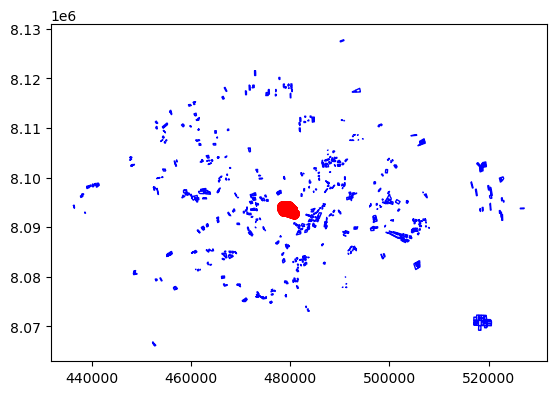

In [147]:
for i, row in gdf_puntos.iterrows():
    ors = row['id_os']
    puntos = filtrar_os_y_quitar_caracteres(gdf_puntos, ors)
    multipoint_gdf = puntos.copy()
    puntos_individuales = crear_puntos_individuales(multipoint_gdf)
    
    lotes_solicidud = definir_lotes_solicitud(puntos_individuales)
    lotes_siembra = definir_lotes_siembra(puntos_individuales)

    
    
    # verificar si algun dataframe esta vacio
    dfs = [df for df in [lotes_solicidud, lotes_siembra] if not df.empty]
    # concatena los dfs no vacios
    concat_plan = pd.concat(dfs, axis=0, ignore_index=True)
    
    plan = agregar_campos_faltantes(concat_plan)
    #RECALCULAR EL AREA
    plan['area'] = plan.geometry.area / 10000
    
    plan.rename(columns={'geometry': 'geom'}, inplace=True)
    plan = plan.set_geometry("geom")
    plan['unidad_01'] = plan['unidad_01'].astype(int)
    plan['unidad_03'] = plan['unidad_03'].astype(int)
    plan['dias'] = plan['dias'].astype(int)
    plan['os'] = plan['os'].astype(int)
    plan['soca'] = plan['soca'].astype(int)
    
    
    
    plan['inst'] = plan['inst'].astype(int)
    plan.to_postgis("parte_diario_ctrl_bio", obtener_engine(), schema="drones_control_bio", if_exists="append")
    
    # CARGAR LOTES A AMIGOCLOUD
    plan_os = obtener_parte_diario_por_id_os(ors)
    crear_kmls(plan_os)
    cargar_a_amigocloud(plan_os)
    
    marcar_como_procesado(ors)

In [12]:
plan_os

NameError: name 'plan_os' is not defined